In [72]:

from experiment_information import *
from data import *
from util import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as np
import numpy as np
import logging
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)
# print("Current code version, ", __version__)

In [74]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "52"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(20)

,experiment_id,experiment_name,duration,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,taus,ps,dp,d,erm_methods,completed,data_model_type
24,2b37d662-9473-4721-8d08-791a73ee104c,Fashin MNIST Trials,18.627376,53,2023-09-27 13:09:31,0,1,"[5.0, 10.0, 15.0]",[0],[1],[0.0],[0.75],0.01,784,"[""sklearn""]",1,FashionMNIST
23,6e8304d9-4844-4dbe-aca8-2d13b5ec46b8,Fashin MNIST Trials,18.722423,53,2023-09-27 13:05:57,0,1,"[5.0, 10.0, 15.0]",[0],[1],[0.0],[0.75],0.01,784,"[""sklearn""]",1,FashionMNIST
22,a90665be-3c20-466b-8e94-0da93d6c7455,Fashin MNIST Trials,20.927577,53,2023-09-27 13:05:10,1,1,"[5.0, 10.0, 15.0]",[0],[1],[0.0],[0.75],0.01,784,"[""sklearn""]",1,FashionMNIST
21,dcf4b63b-2b72-4079-a356-4b09f288647a,Fashin MNIST Trials,20.493694,53,2023-09-27 13:04:30,1,1,"[5.0, 10.0, 15.0]",[0],[1],[0.0],[0.75],0.01,784,"[""sklearn""]",1,FashionMNIST
20,03339a77-c977-4ab3-aa8f-cba27ac1114e,Fashin MNIST Trials,21.704748,53,2023-09-27 13:03:47,1,1,"[5.0, 10.0, 15.0]",[0],[1],[0.0],[0.75],0.01,784,"[""sklearn""]",1,FashionMNIST
19,c937f251-dad5-485b-8d48-6c703c50d98a,Fashin MNIST Trials,22.099724,53,2023-09-27 12:58:48,1,1,"[5.0, 10.0, 15.0]",[0],[1],[0.0],[0.75],0.01,784,"[""sklearn""]",1,FashionMNIST
17,e7455073-a22b-4e0a-9c71-f204a8fd73a5,Fashin MNIST Trials,19.825527,53,2023-09-27 12:54:39,1,1,"[5.0, 10.0, 15.0]",[0],[1],[0.0],[0.75],0.01,784,"[""sklearn""]",1,FashionMNIST
15,c9776e87-4eb6-4d5a-813f-56907c258384,Optimal Lambda Default Experiment,102.840795,53,2023-09-27 12:49:52,1,3,"[5.0, 7.0, 9.0, 11.0, 13.0, 15.0]",[0],[1],[0.0],[0.75],0.01,784,"[""sklearn""]",1,FashionMNIST
14,fdc2275f-48a8-49b2-ad65-e7a9113b6c81,Optimal Lambda Default Experiment,100.314627,53,2023-09-27 11:42:12,1,3,"[5.0, 7.0, 9.0, 11.0, 13.0, 15.0]",[0],[1],[0.0],[0.75],0.01,784,"[""sklearn""]",1,FashionMNIST
13,7ca2f94a-c558-4eae-919c-53da1110019c,Optimal Lambda Default Experiment,103.091829,53,2023-09-27 11:40:23,1,3,"[5.0, 7.0, 9.0, 11.0, 13.0, 15.0]",[0],[1],[0.0],[0.75],0.01,784,"[""sklearn""]",1,FashionMNIST


In [75]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [76]:
# extract and print the top experiment_id
experiment_id = df_experiments.iloc[0]["experiment_id"]
print(experiment_id)
# experiment_id = "031d5eb9-bf79-4ffb-9fb3-eabedcd350b0"

# This guy was interesting in version 25 for the q- state evolution adaptation
# a2a3016c-8264-4599-ac8f-b457da2790ba
# this guy is interesting in version 28! q-state evolution - best erm so far, close call
# b5f9faf7-ec66-490c-ac99-841888f3fedf
# experiment_id = "b5f9faf7-ec66-490c-ac99-841888f3fedf"
# version 30: 7b921b61-0b48-48a8-8ead-78bc5804597f - q state evolution. Overlaps match except for lambda = 1 in the settings tau=0,2, lam=5*1e-5 for epsilon up to 0.7
# version 30: f92b13d1-c020-46c0-a3cd-5e0578b831a5 - Q state evolution. Same setting as above but not matching overlap.

# version 36 on cluster: 58b544ab-3536-4eb7-bbb9-743f471f6bb3

2b37d662-9473-4721-8d08-791a73ee104c


In [77]:
df_state_evolution["alpha"]

0      5.0
1      7.0
2      9.0
3      5.0
4      5.0
5      7.0
6      9.0
7     11.0
8      5.0
9      5.0
10     7.0
11     9.0
12    11.0
13    13.0
14    15.0
15     5.0
16     7.0
17     9.0
18    11.0
19    13.0
20    15.0
21     5.0
22     7.0
23     9.0
24    11.0
25    13.0
26    15.0
27    10.0
28    10.0
29     5.0
30    15.0
31    10.0
32     5.0
33    15.0
34    10.0
35     5.0
36    15.0
37    10.0
38     5.0
39    15.0
40    10.0
41     5.0
42    15.0
43    10.0
44     5.0
45    15.0
Name: alpha, dtype: float64

In [78]:
df_erm["alpha"]

0      5.0
1      5.0
2      5.0
3      7.0
4      7.0
5      7.0
6      9.0
7      9.0
8      9.0
9     11.0
10    11.0
11    11.0
12    13.0
13    13.0
14    13.0
15    15.0
16    15.0
17    15.0
18     5.0
19     5.0
20     5.0
21     7.0
22     7.0
23     7.0
24     9.0
25     9.0
26     9.0
27    11.0
28    11.0
29    11.0
30    13.0
31    13.0
32    13.0
33    15.0
34    15.0
35    15.0
36     5.0
37    10.0
38    15.0
39     5.0
40    10.0
41     5.0
42    10.0
43    15.0
44     5.0
45    10.0
46    15.0
47    10.0
48     5.0
49    15.0
50     5.0
51    10.0
52    15.0
53     5.0
54    10.0
55    15.0
56     5.0
57    10.0
58    15.0
Name: alpha, dtype: float64

In [79]:
round_to = 2
def my_floor(a, precision=round_to):
    return np.round(a - 0.5 * 10**(-precision), precision)
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
# ceil the alpha values to 1 decimal
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))
erm = df_erm[df_erm["experiment_id" ] == experiment_id]
# gd = erm[erm["chosen_minimizer"] == "gd"]
# gd = erm[erm["chosen_minimizer"] == "L-BFGS-B"]
# gd = erm[erm["chosen_minimizer"] == "logistic"]
gd = erm[erm["chosen_minimizer"] == "sklearn"]
# ceil the alpha values to 1 decimal
gd["alpha"] = gd["alpha"].apply(lambda x: my_floor(x,precision=round_to))
# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam"]) #,"p"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam"]) #,"p"
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","m","cosb","training_loss","estimation_error","sigma_hat","q_hat","m_hat","adversarial_generalization_error","training_error"]] #,"calibration"
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb", "training_error","d", "training_loss","test_loss","adversarial_generalization_error_erm","adversarial_generalization_error_overlap"]] #"erm_calibration","analytical_calibration"
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm','m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm',"training_loss_state_evolution","training_loss_erm","training_error_erm","d_erm","test_loss_erm","estimation_error_state_evolution","sigma_hat_state_evolution","q_hat_state_evolution","m_hat_state_evolution","adversarial_generalization_error_state_evolution","adversarial_generalization_error_overlap_erm","adversarial_generalization_error_erm_erm","training_error_state_evolution"]] # ,"erm_calibration_erm","analytical_calibration_erm","calibration_state_evolution"
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3]).agg([np.mean,np.std]) #,4
# display all columns
pd.set_option('display.max_columns', None)
# # display all rows
# pd.set_option('display.max_rows', None)
df

generalization_error_state_evolution      \
                                                      mean std   
alpha epsilon tau lam                                            
5.00  0.0     0.0 1.0                                  NaN NaN   
9.99  0.0     0.0 1.0                                  NaN NaN   
15.00 0.0     0.0 1.0                                  NaN NaN   

                      generalization_error_erm_erm      \
                                              mean std   
alpha epsilon tau lam                                    
5.00  0.0     0.0 1.0                       0.0010 NaN   
9.99  0.0     0.0 1.0                       0.0005 NaN   
15.00 0.0     0.0 1.0                       0.0005 NaN   

                      generalization_error_overlap_erm      \
                                                  mean std   
alpha epsilon tau lam                                        
5.00  0.0     0.0 1.0                              NaN NaN   
9.99  0.0     0.0 1.0                              NaN NaN   
15.00 0.0     0.0 1.0                              NaN NaN   

                      sigma_state_evolution     q_state_evolution      \
                                       mean std              mean std   
alpha epsilon tau lam                                                   
5.00  0.0     0.0 1.0                   NaN NaN               NaN NaN   
9.99  0.0     0.0 1.0                   NaN NaN               NaN NaN   
15.00 0.0     0.0 1.0                   NaN NaN               NaN NaN   

                          Q_erm     m_state_evolution     m_erm      \
                           mean std              mean std  mean std   
alpha epsilon tau lam                                                 
5.00  0.0     0.0 1.0  0.003166 NaN               NaN NaN   1.0 NaN   
9.99  0.0     0.0 1.0  0.004067 NaN               NaN NaN   1.0 NaN   
15.00 0.0     0.0 1.0  0.005132 NaN               NaN NaN   1.0 NaN   

                      cosb_state_evolution       cosb_erm     rho_erm      \
                                      mean std       mean std    mean std   
alpha epsilon tau lam                                                       
5.00  0.0     0.0 1.0                  NaN NaN  17.771549 NaN     1.0 NaN   
9.99  0.0     0.0 1.0                  NaN NaN  15.680642 NaN     1.0 NaN   
15.00 0.0     0.0 1.0                  NaN NaN  13.958718 NaN     1.0 NaN   

                      training_loss_state_evolution     training_loss_erm      \
                                               mean std              mean std   
alpha epsilon tau lam                                                           
5.00  0.0     0.0 1.0                           NaN NaN          0.000425 NaN   
9.99  0.0     0.0 1.0                           NaN NaN          0.000275 NaN   
15.00 0.0     0.0 1.0                           NaN NaN          0.000234 NaN   

                      training_error_erm      d_erm     test_loss_erm      \
                                    mean std   mean std          mean std   
alpha epsilon tau lam                                                       
5.00  0.0     0.0 1.0                0.0 NaN  784.0 NaN      0.002044 NaN   
9.99  0.0     0.0 1.0                0.0 NaN  784.0 NaN      0.002289 NaN   
15.00 0.0     0.0 1.0                0.0 NaN  784.0 NaN      0.001681 NaN   

                      estimation_error_state_evolution      \
                                                  mean std   
alpha epsilon tau lam                                        
5.00  0.0     0.0 1.0                              NaN NaN   
9.99  0.0     0.0 1.0                              NaN NaN   
15.00 0.0     0.0 1.0                              NaN NaN   

                      sigma_hat_state_evolution     q_hat_state_evolution      \
                                           mean std                  mean std   
alpha epsilon tau lam                                                           
5.00  0.

In [80]:
def extract_optimal_lambda(alpha, epsilon, tau, recursion_depth = 0):
    # extract or compute optimal lamba and plot it as a vertical line
    filename = f"experiments/optimal_lambdas.csv"
    # read filename as pandas dataframe
    df_optimal_lambdas = pd.read_csv(filename)
    # filter the dataframe for the current value of tau, epsilon and alpha
    optimal_lambdas_subset = df_optimal_lambdas[(df_optimal_lambdas["tau"] == tau) & (df_optimal_lambdas["epsilon"] == epsilon) & (df_optimal_lambdas["alpha"] == alpha)]
    # extract the optimal lambda
    try:
        optimal_lambda = optimal_lambdas_subset["lambda"].values[0]
        return optimal_lambda
    except:
        if recursion_depth > 0:
            return None
        print("Optimal lambda not found. Computing it now.")
        command = f"python optimal_choice.py {alpha} {epsilon} {tau}"
        import subprocess
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        process.wait()
        return extract_optimal_lambda(alpha,epsilon,tau,recursion_depth=recursion_depth+1)

In [81]:
first_iteration = "tau"
second_iteration = None # "lam"
target = "alpha"
sweep = "epsilon"
def create_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True, fix_a_variable = None, variable_value = None, filename=None):
    df2 = df.reset_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    for tau in df2[first_iteration].unique():

        iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

        for lam in iterate_over:

            # Filter the dataframe for the current values of tau and lam
            if second_iteration is None:
                data = df2[(df2[first_iteration] == tau)]
            else:
                data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam)]

            if fix_a_variable is not None:
                data = data[data[fix_a_variable] == variable_value]
            
            for i, epsilon in enumerate(data[sweep].unique()):
                # Filter the dataframe for the current value of epsilon
                epsilon_subset = data[data[sweep] == epsilon]

                # Plot the state_evolution results as a line
                if state_evolution_name is not None:
                    if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                        plt.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep}: {epsilon}', color=palette[i])
                    else:
                        plt.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon}', color=palette[i])
                
                # Plot the gradient_descent results as points with error bars
                if gd_name is not None:
                    try:
                        plt.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                    except:
                        pass

                if error_name == "Generalization Error" and target == "lam":
                    optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau)
                    # plot the optimal lambda as a vertical line
                    plt.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

            
            if log_x:
                plt.xscale('log')
            if log_y:
                plt.yscale('log')

            # Add labels and title
            plt.xlabel(target)
            plt.ylabel(error_name)
            if fix_a_variable is not None:
                if second_iteration is None:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, d: {d} - {fix_a_variable}: {variable_value}')
                else:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d} - {fix_a_variable}: {variable_value}')
            else:
                if second_iteration is None:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, d: {d}')
                else:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d}')
            # Add a legend
            plt.legend()

            # add a grid
            plt.grid()

            plt.tight_layout()

            if fix_a_variable is not None:
                name = f"{error_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
            else:
                name = f"{error_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
            # Save the plot as svg
            if filename is not None:
                plt.savefig(f"Assets/{filename}_{name}.pdf", bbox_inches='tight')

            # Show the plot
            plt.show()

In [82]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

In [83]:
# create_plot(df,"Optimal Lambda", "lam", None,filename="Optimal_lambda")

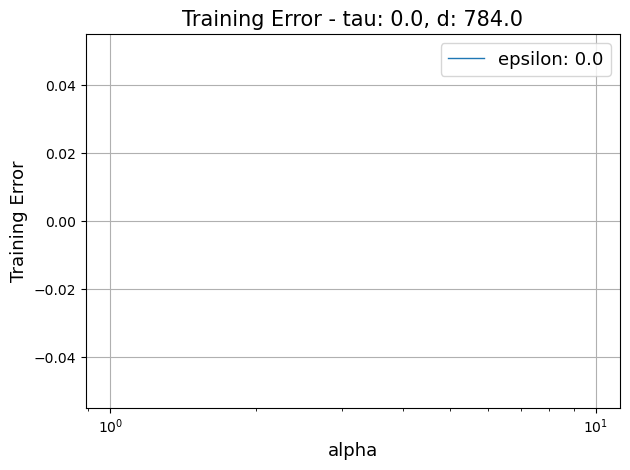

In [84]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm",log_y=False)

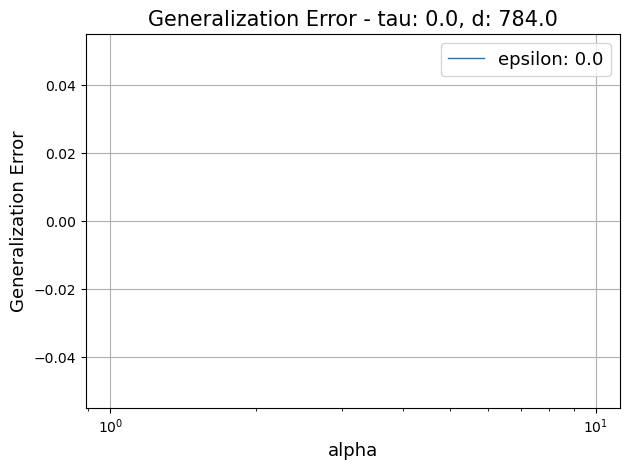

In [85]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=False)

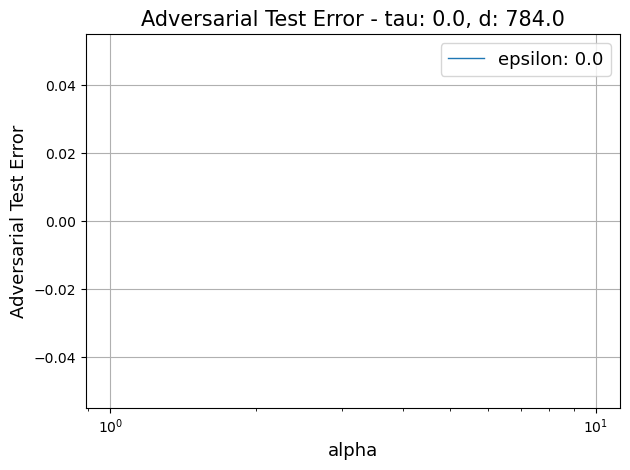

In [86]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm_erm",log_y=False)

In [87]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=True)

ValueError: Data has no positive values, and therefore can not be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x143689b80> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 640x480 with 1 Axes>

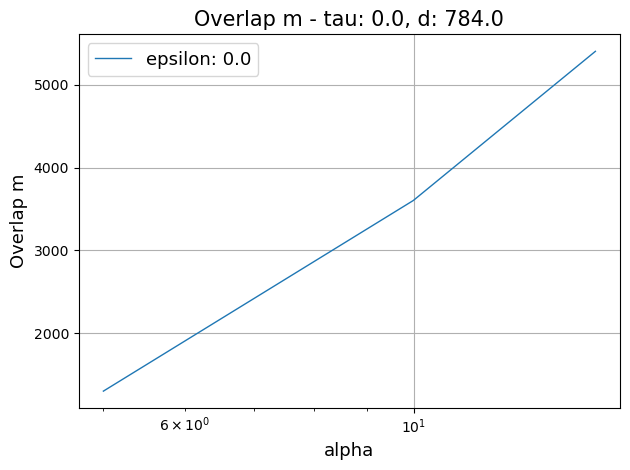

In [ ]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_y=False)

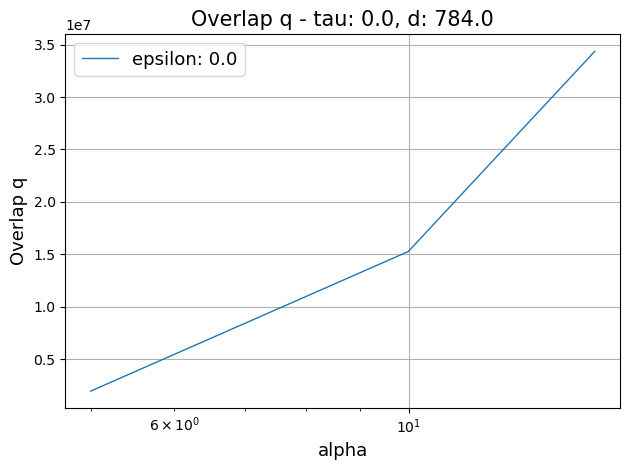

In [ ]:
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_y=False)

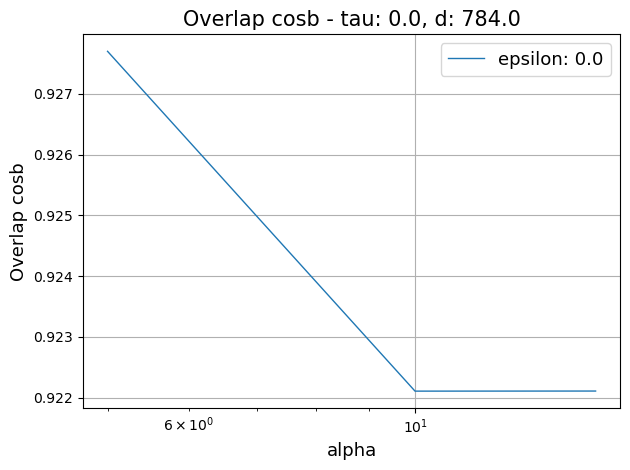

In [ ]:
create_plot(df, "Overlap cosb", "cosb_state_evolution","cosb_erm",log_y=False)

In [ ]:
# subset df to keep only where p = 0.5
# p = 0.75
# dfp = df[df.index.get_level_values("p") == p]
# # remove epsilon = 1
# # dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

# create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# # erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

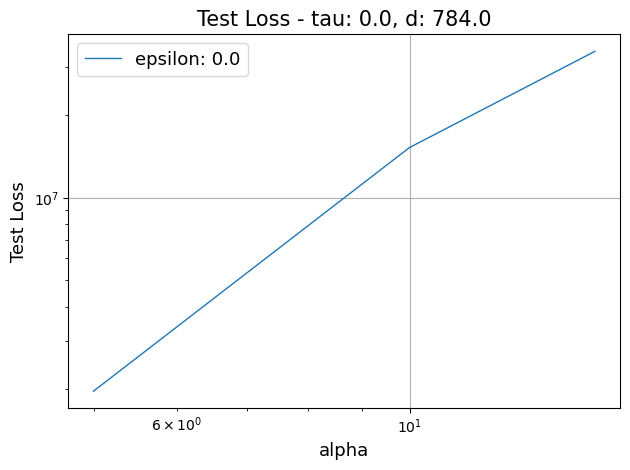

In [ ]:
# plot test loss erm
create_plot(df, "Test Loss", "estimation_error_state_evolution","test_loss_erm",log_y=True)

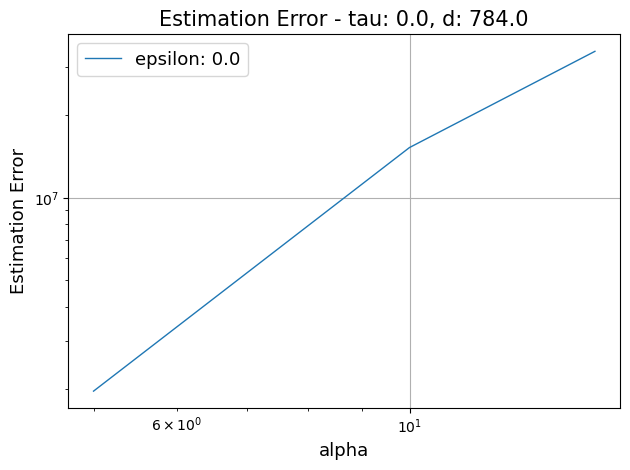

In [ ]:
# plot estimation_error_state_evolution
create_plot(df, "Estimation Error", "estimation_error_state_evolution",None,log_y=True)

## Log-Log Plots of overlaps in State_evolution

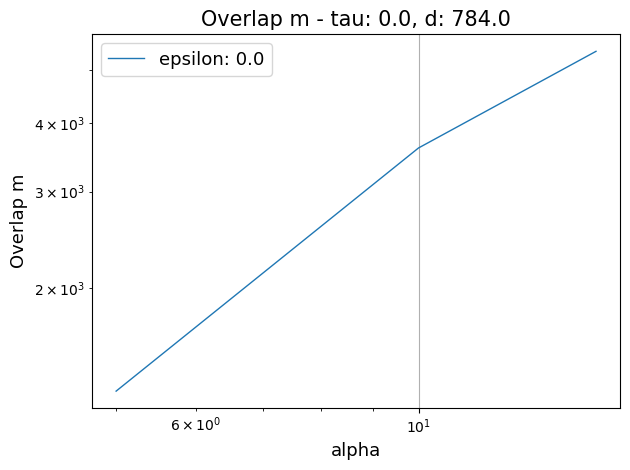

In [ ]:
# create a log-log plot of the overlap m
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_x=True, log_y=True)

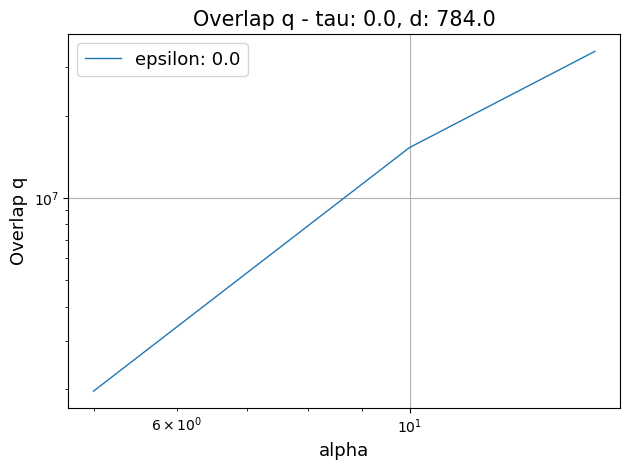

In [ ]:
# create a log-log plot of the overlap q
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_x=True, log_y=True)

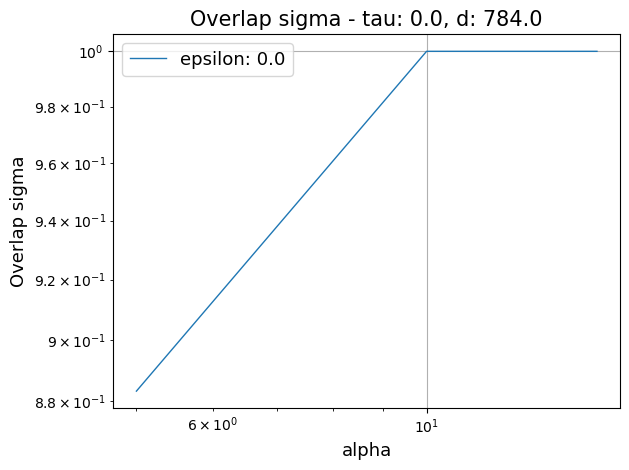

In [ ]:
# create a log-log plot of the overlap sigma
create_plot(df, "Overlap sigma", "sigma_state_evolution",None, log_x=True, log_y=True)

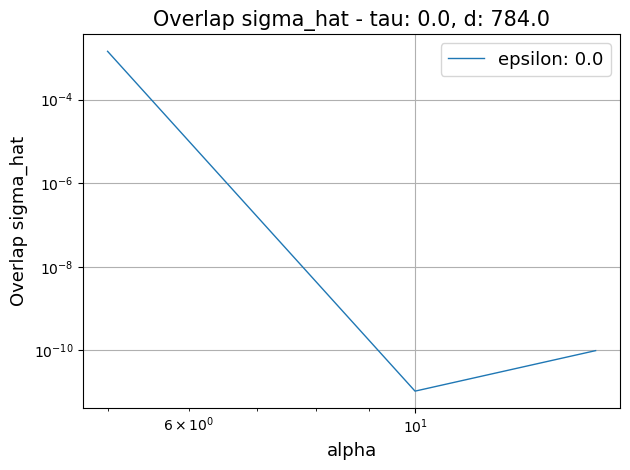

In [ ]:
# create a log-log plot of the overlap sigma_hat
create_plot(df, "Overlap sigma_hat", "sigma_hat_state_evolution",None, log_x=True, log_y=True)

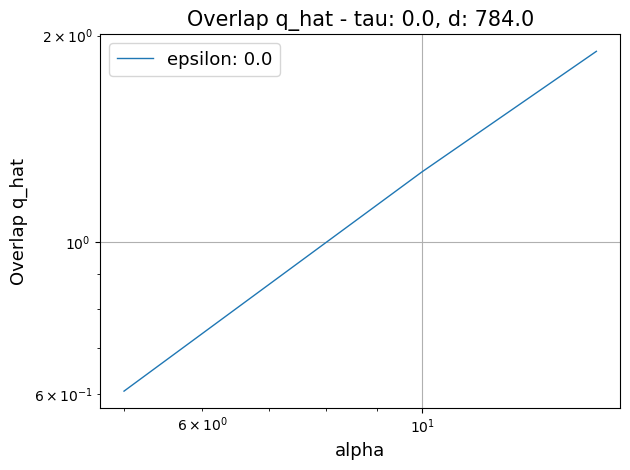

In [ ]:
# create a log-log plot of the overlap q_hat
create_plot(df, "Overlap q_hat", "q_hat_state_evolution",None, log_x=True, log_y=True)

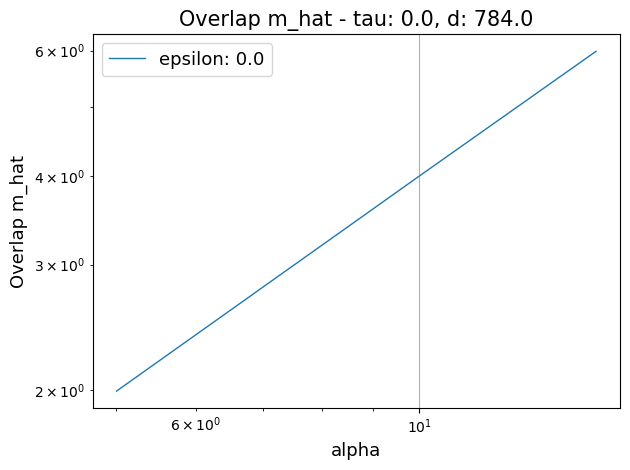

In [ ]:
# create a log-log plot of the overlap m_hat
create_plot(df, "Overlap m_hat", "m_hat_state_evolution",None, log_x=True, log_y=True)

In [88]:
# # Create a SweepExperiment
def get_default_experiment():
    state_evolution_repetitions: int = 1
    erm_repetitions: int = 3
    alphas: np.ndarray = np.linspace(5,15,3)
    epsilons: np.ndarray = np.array([0]) # np.linspace(0,1,5)
    lambdas: np.ndarray = np.array([1])
    taus: np.ndarray = np.array([0.0])
    ps: np.ndarray = np.array([0.75]) 
    dp: float = 0.01
    d: int = 784
    erm_methods: list = ["sklearn"] #"optimal_lambda"
    experiment_name: str = "Fashin MNIST Trials"
    data_model_type: DataModelType = DataModelType.FashionMNIST
    experiment = ExperimentInformation(state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,taus,d,erm_methods,ps,dp, data_model_type, experiment_name)
    return experiment
experiment = get_default_experiment()
# # use json dump to save the experiment parameters
with open("experiments/sweep_experiment_alpha_mnist.json","w") as f:
    # use the NumpyEncoder to encode numpy arrays
    json.dump(experiment.__dict__,f,cls=NumpyEncoder)

In [ ]:
DataModelType["FashionMNIST"].name

'FashionMNIST'